In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from multiprocessing import Pool
from pathlib import Path
import sys

# set path to the utils
notebook_dir = os.getcwd()
notebook_name = "check_generated_data.ipynb"

PATH = Path(notebook_dir) / Path(notebook_name) #Path("/home/simon/Documents/scripts/views_pipeline/models/purple_alien/notebooks/test_to_prediction_store.ipynb")

sys.path.insert(0, str(Path(*[i for i in PATH.parts[:PATH.parts.index("VIEWS_FAO_index")+1]]) / "src/utils"))   

from set_paths import setup_project_paths
setup_project_paths(PATH)

from utils_plotting import plot_time_series_data, plot_random_monthly_and_yearly_data
from utils_annual_aggregation import aggregate_monthly_to_yearly
from utils_feature_eng_per_100k import feature_eng_fat_per_100k
#from utils_cumulative_distribution import calculate_global_cumulative_distribution
from utils_global_probabilities import calculate_global_probabilities

In [2]:
print(np.__version__) # 1.26.4 used
print(pd.__version__) # 2.2.1 used
print(matplotlib.__version__) # 3.8.4 used
print(sns.__version__) # 0.13.2 used

1.26.4
2.2.1
3.8.4
0.13.2


# Load data

In [3]:
PATH_df = "/home/simon/Documents/scripts/VIEWS_FAO_index/data/raw_viewser/simon_full_base_01_viewser_df.pkl"
df_monthly = pd.read_pickle(PATH_df)
df_yearly = aggregate_monthly_to_yearly(df_monthly)

# validate_dataframe(df)

df_monthly = feature_eng_fat_per_100k(df_monthly)
df_yearly = feature_eng_fat_per_100k(df_yearly)

# now loop through the columns and calculate probabilities
columns = ['sb_best', 'ns_best', 'os_best', 'total_best', 'fatalities_per_100k', 'sb_per_100k', 'ns_per_100k', 'os_per_100k']
for col in columns:
    df_monthly = calculate_global_probabilities(df_monthly, col, 'month_id')
    df_yearly = calculate_global_probabilities(df_yearly, col, 'year_id')
#    df = calculate_all_country_probabilities(df, col, 'month_id')

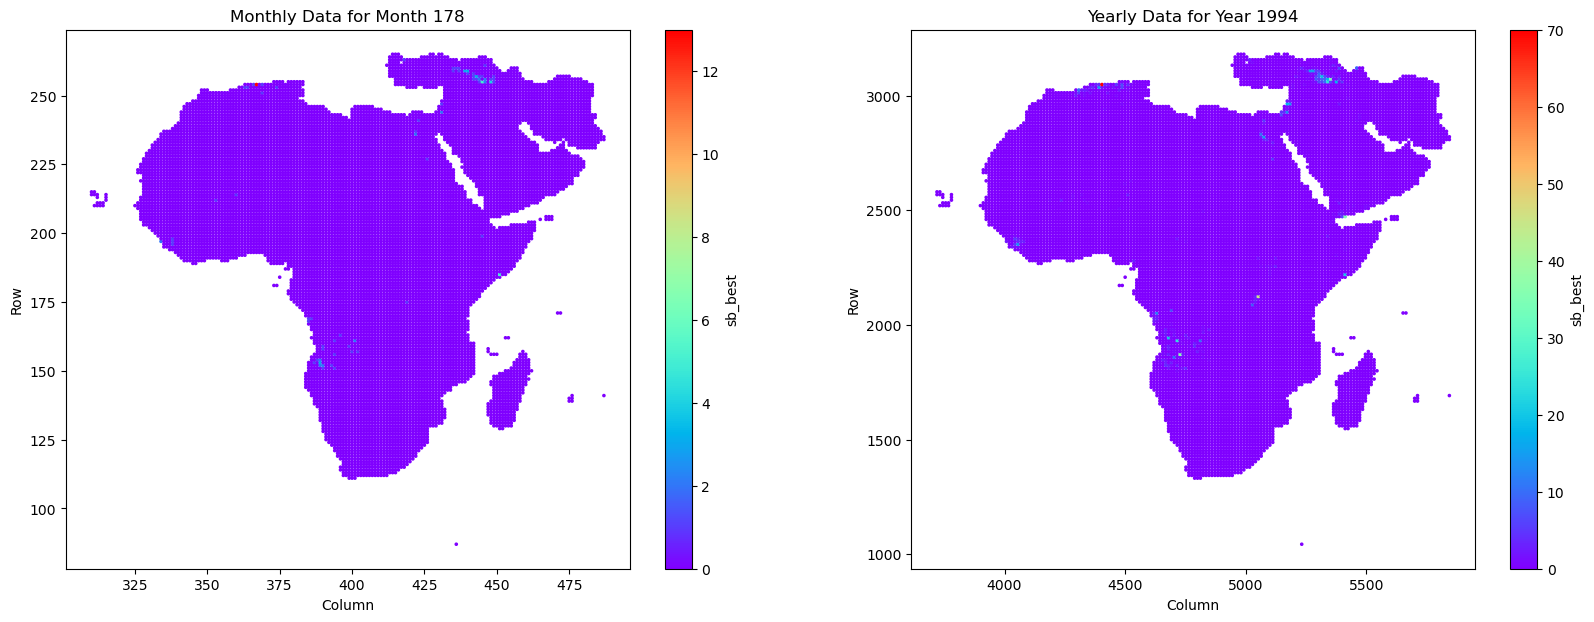

In [4]:
plot_random_monthly_and_yearly_data(df_monthly, df_yearly, feature = 'sb_best')

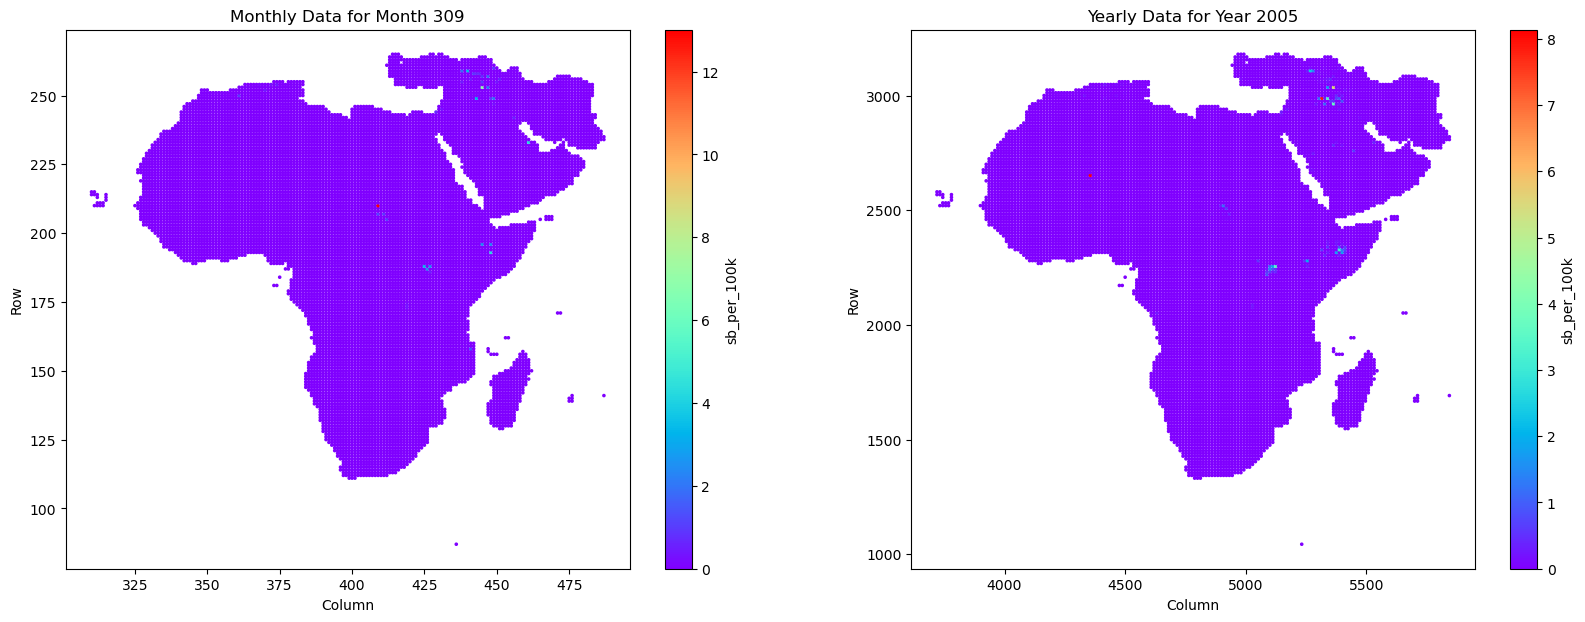

In [7]:
plot_random_monthly_and_yearly_data(df_monthly, df_yearly, feature = 'sb_per_100k')

KeyError: 'sb_per_100k_time_unit_likelihood'

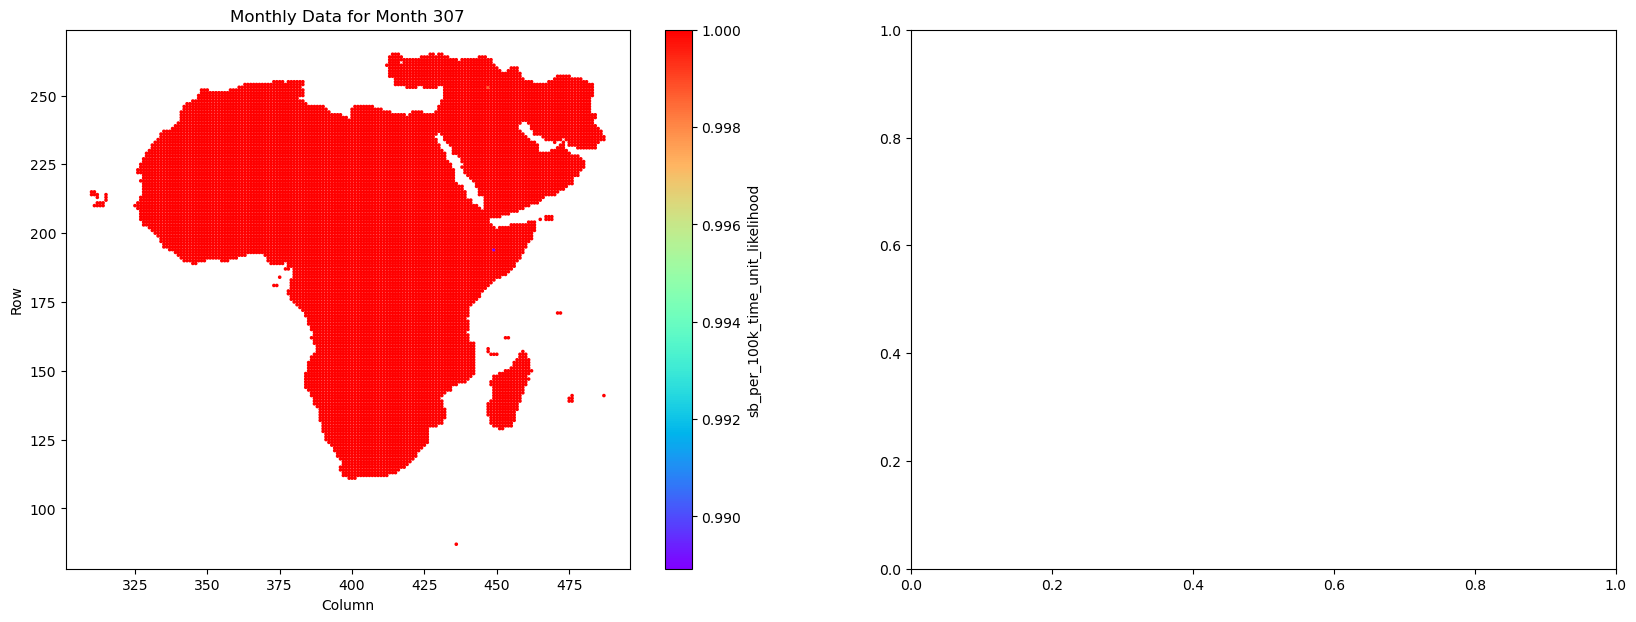

In [5]:
# plot the new global probabilities
plot_random_monthly_and_yearly_data(df_monthly, df_yearly, feature = 'sb_per_100k_time_unit_likelihood')
plot_random_monthly_and_yearly_data(df_monthly, df_yearly, feature = 'sb_per_100k_unit_likelihood')

# Starting with monthly

In [ ]:
def calculate_country_probabilities_per_country(country_df: pd.DataFrame, value_col: str, time_col: str) -> pd.DataFrame:
    """
    Calculate the probabilities p_i and P_i for each unique value in the dataset for a given country.

    Parameters:
    - country_df (pd.DataFrame): DataFrame containing data for a single country.
    - value_col (str): The column name for the voxel values.
    - time_col (str): The column name for the time periods.

    Returns:
    - pd.DataFrame: DataFrame with added columns for p_i and P_i probabilities.
    """
    # Calculate cumulative distribution
    cumulative_distribution = country_df[value_col].rank(method='max') / len(country_df)
    
    # Calculate total number of voxels
    total_units = len(country_df)
    
    # Calculate number of units per time unit
    num_units_per_time_unit = country_df.groupby(time_col).size().mean()
    
    # Calculate p_i
    p_i = cumulative_distribution / total_units
    
    # Calculate P_i
    P_i = 1 - (1 - p_i)**num_units_per_time_unit
    
    # Ensure p_i and P_i for 0 are set to 1
    zero_mask = country_df[value_col] == 0
    p_i[zero_mask] = 1
    P_i[zero_mask] = 1
    
    # Add results to DataFrame
    country_df[f'{value_col}_unit_likelihood_country'] = p_i.values
    country_df[f'{value_col}_time_unit_likelihood_country'] = P_i.values
    
    return country_df

In [ ]:
def calculate_all_country_probabilities(df: pd.DataFrame, value_col: str, time_col: str) -> pd.DataFrame:
    """
    Calculate the probabilities p_i and P_i for each unique value in the dataset for all countries.

    Parameters:
    - df (pd.DataFrame): DataFrame containing data for all countries.
    - value_col (str): The column name for the voxel values.
    - time_col (str): The column name for the time periods.
    - stat_measure (str): The statistical measure to use ('mean', 'median', 'mode').

    Returns:
    - pd.DataFrame: DataFrame with added columns for p_i and P_i probabilities for all countries.
    """
    if df.empty:
        raise ValueError("The input DataFrame is empty.")
    
    if value_col not in df.columns:
        raise ValueError(f"The specified value column '{value_col}' does not exist in the DataFrame.")
    
    if time_col not in df.columns:
        raise ValueError(f"The specified time column '{time_col}' does not exist in the DataFrame.")
    
    countries = df['c_id'].unique()
    
    with Pool() as pool:
        results = pool.starmap(
            calculate_country_probabilities_per_country, 
            [(df[df['c_id'] == country], value_col, time_col) for country in countries]
        )
    
    result_df = pd.concat(results, ignore_index=True)
    
    return result_df

In [ ]:
def calculate_return_periods(df, p_i_col, P_i_col):
    """
    Calculate the expected number of time periods and voxels to survey to find at least one voxel with a value greater than or equal to i.

    Parameters:
    df (pd.DataFrame): Dataframe containing values, p_i, and P_i.
    p_i_col (str): The name of the column containing unit likelihoods (p_i).
    P_i_col (str): The name of the column containing time unit likelihoods (P_i).

    Returns:
    pd.DataFrame: The original dataframe with added columns for time unit return periods (E_i) and unit return periods (E_{i}^{voxels}).
    """
    # Infer value_col by removing the '_unit_likelihood' suffix from p_i_col
    value_col = p_i_col.replace("_unit_likelihood", "")

    # if the value_col ends on "_contry" we need to remove that as well
    if value_col.endswith("_country"):
        value_col = value_col.replace("_country", "")

    # Save it as a suffix for the new columns
        suffix = "_country"

    else:
        suffix = ""

    # Calculate E_i = 1 / P_i
    df[f'{value_col}_time_unit_return_period{suffix}'] = 1 / df[P_i_col]
    
    # Calculate E_{i}^{voxels} = 1 / p_i
    df[f'{value_col}_unit_return_period{suffix}'] = 1 / df[p_i_col]
    
    return df

# Now put it all toghter

In [ ]:
def feature_engineering_pipeline(df):

    # Perform feature engineering to calculate fatalities per 100,000 population
    df = feature_eng_fat_per_100k(df)

    # now loop through the columns and calculate probabilities
    columns = ['sb_best', 'ns_best', 'os_best', 'total_best', 'fatalities_per_100k', 'sb_per_100k', 'ns_per_100k', 'os_per_100k']
    for col in columns:
        df = calculate_global_probabilities(df, col, 'month_id')
        df = calculate_all_country_probabilities(df, col, 'month_id')

    # now loop through the columns and calculate return periods
    for col in columns:
        df = calculate_return_periods(df, f'{col}_unit_likelihood', f'{col}_time_unit_likelihood')
        df = calculate_return_periods(df, f'{col}_unit_likelihood_country', f'{col}_time_unit_likelihood_country')

    # check that all the new expected columns are created
    new_columns = [
        'total_best', 'fatalities_per_100k', 'sb_per_100k', 'ns_per_100k', 'os_per_100k',
        'fatalities_per_100k_unit_likelihood', 'fatalities_per_100k_time_unit_likelihood',
        'sb_per_100k_unit_likelihood', 'sb_per_100k_time_unit_likelihood',
        'ns_per_100k_unit_likelihood', 'ns_per_100k_time_unit_likelihood',
        'os_per_100k_unit_likelihood', 'os_per_100k_time_unit_likelihood',
        'total_best_unit_likelihood', 'total_best_time_unit_likelihood',
        'fatalities_per_100k_unit_return_period', 'fatalities_per_100k_time_unit_return_period',
        'sb_per_100k_unit_return_period', 'sb_per_100k_time_unit_return_period',
        'ns_per_100k_unit_return_period', 'ns_per_100k_time_unit_return_period',
        'os_per_100k_unit_return_period', 'os_per_100k_time_unit_return_period',
        'total_best_unit_return_period', 'total_best_time_unit_return_period',
        'fatalities_per_100k_unit_likelihood_country', 'fatalities_per_100k_time_unit_likelihood_country',
        'sb_per_100k_unit_likelihood_country', 'sb_per_100k_time_unit_likelihood_country',
        'ns_per_100k_unit_likelihood_country', 'ns_per_100k_time_unit_likelihood_country',
        'os_per_100k_unit_likelihood_country', 'os_per_100k_time_unit_likelihood_country',
        'total_best_unit_likelihood_country', 'total_best_time_unit_likelihood_country',
        'fatalities_per_100k_unit_return_period_country', 'fatalities_per_100k_time_unit_return_period_country',
        'sb_per_100k_unit_return_period_country', 'sb_per_100k_time_unit_return_period_country',
        'ns_per_100k_unit_return_period_country', 'ns_per_100k_time_unit_return_period_country',
        'os_per_100k_unit_return_period_country', 'os_per_100k_time_unit_return_period_country',
        'total_best_unit_return_period_country', 'total_best_time_unit_return_period_country'
    ]
    
    for col in new_columns:
        assert col in df.columns, f"Column {col} is missing from the DataFrame"

    return df

In [ ]:
df_monthly = feature_engineering_pipeline(df)

In [ ]:
df_monthly

# Plotting:

In [ ]:
def plot_time_series_data(df, time_ids, time_id_name, columns, figsize=(18, 25), cmap="rainbow", alpha=0.6, marker='.', s=6):
    """
    Plots a grid of scatter plots for specified time_ids and columns.

    Parameters:
    - df: pandas DataFrame containing the data
    - time_ids: list of time_ids to plot (e.g., months, years, weeks)
    - time_id_name: name of the time_id column (e.g 'month_id', 'year_id', 'week_id')
    - columns: list of columns to plot
    - figsize: tuple specifying the figure size
    - cmap: colormap for the scatter plots
    - alpha: transparency level of the markers
    - marker: marker style for the scatter plots
    - s: size of the markers
    """
    
    # Create a subplot grid
    fig, axes = plt.subplots(nrows=len(columns), ncols=len(time_ids), figsize=figsize)

    # Iterate over the rows and columns to create each subplot
    for i, col in enumerate(columns):

        # if the columns name includes "likelihood" we the reverse the colormap
        if "likelihood" in col:
            cmap_suffix = "_r"

        else:
            cmap_suffix = ""

        for j, time_id in enumerate(time_ids):
            ax = axes[i, j]
            filtered_df = df[df[time_id_name] == time_id]
            scatter = ax.scatter(filtered_df["col"], filtered_df["row"], c=filtered_df[col], cmap=f'{cmap}{cmap_suffix}', alpha=alpha, marker=marker, s=s)
            
            # Add a color bar if the value is a float
            if filtered_df[col].dtype == "float64":
                cbar = plt.colorbar(scatter, ax=ax)
                cbar.set_label(col)
            
            # Add labels and title
            ax.set_xlabel('Column')
            ax.set_ylabel('Row')
            ax.set_title(f'{col} for Time ID {time_id}')
            
            # Add grid
            ax.grid(True, linestyle='--', alpha=0.5)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
new_columns = [
        'total_best', 'fatalities_per_100k', 'sb_per_100k', 'ns_per_100k', 'os_per_100k',
        'fatalities_per_100k_unit_likelihood', 'fatalities_per_100k_time_unit_likelihood',
        'sb_per_100k_unit_likelihood', 'sb_per_100k_time_unit_likelihood',
        'ns_per_100k_unit_likelihood', 'ns_per_100k_time_unit_likelihood',
        'os_per_100k_unit_likelihood', 'os_per_100k_time_unit_likelihood',
        'total_best_unit_likelihood', 'total_best_time_unit_likelihood',
        'fatalities_per_100k_unit_return_period', 'fatalities_per_100k_time_unit_return_period',
        'sb_per_100k_unit_return_period', 'sb_per_100k_time_unit_return_period',
        'ns_per_100k_unit_return_period', 'ns_per_100k_time_unit_return_period',
        'os_per_100k_unit_return_period', 'os_per_100k_time_unit_return_period',
        'total_best_unit_return_period', 'total_best_time_unit_return_period',
        'fatalities_per_100k_unit_likelihood_country', 'fatalities_per_100k_time_unit_likelihood_country',
        'sb_per_100k_unit_likelihood_country', 'sb_per_100k_time_unit_likelihood_country',
        'ns_per_100k_unit_likelihood_country', 'ns_per_100k_time_unit_likelihood_country',
        'os_per_100k_unit_likelihood_country', 'os_per_100k_time_unit_likelihood_country',
        'total_best_unit_likelihood_country', 'total_best_time_unit_likelihood_country',
        'fatalities_per_100k_unit_return_period_country', 'fatalities_per_100k_time_unit_return_period_country',
        'sb_per_100k_unit_return_period_country', 'sb_per_100k_time_unit_return_period_country',
        'ns_per_100k_unit_return_period_country', 'ns_per_100k_time_unit_return_period_country',
        'os_per_100k_unit_return_period_country', 'os_per_100k_time_unit_return_period_country',
        'total_best_unit_return_period_country', 'total_best_time_unit_return_period_country']

time_ids = [121, 318, 528]

plot_time_series_data(df_monthly, time_ids, "month_id", new_columns, figsize=(18, 200), cmap = "rainbow", alpha=0.6, marker='.', s=6)

In [ ]:
# pickle the monthly df
df_monthly.to_pickle("/home/simon/Documents/scripts/VIEWS_FAO_index/data/processed/simon_full_base_01_viewser_df_rp_monthly.pkl")

In [ ]:
df_monthly